# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.02014825 -0.1790826   0.00155752  0.32257154] 0 1.0 False {}
state, action, reward, done, info
[-0.0237299   0.01601714  0.00800895  0.0303802 ] 1 1.0 False {}
state, action, reward, done, info
[-0.02340956  0.21102333  0.00861656 -0.2597651 ] 1 1.0 False {}
state, action, reward, done, info
[-0.01918909  0.01577943  0.00342125  0.0356231 ] 0 1.0 False {}
state, action, reward, done, info
[-0.0188735   0.21085216  0.00413372 -0.25597842] 1 1.0 False {}
state, action, reward, done, info
[-0.01465646  0.40591485 -0.00098585 -0.54735464] 1 1.0 False {}
state, action, reward, done, info
[-0.00653816  0.60105063 -0.01193295 -0.84034802] 1 1.0 False {}
state, action, reward, done, info
[ 0.00548285  0.79633345 -0.02873991 -1.13675959] 1 1.0 False {}
state, action, reward, done, info
[ 0.02140952  0.99181931 -0.0514751  -1.43831566] 1 1.0 False {}
state, action, reward, done, info
[ 0.04124591  1.18753642 -0.08024141 -1.74662948] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.187536424179984 -1.7466294753751983


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [7]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [8]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [9]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [10]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [12]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            # feed_dict={model.states: next_states}
            # next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)
            feed_dict={model.states: states}
            rewards_fake = sess.run(model.rewards_fake, feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 2.0 Training d_loss: 1.3724 Training g_loss: 0.6825 Training q_loss: 0.3718 Explore P: 0.9998
Episode: 1 Total reward: 23.0 Training d_loss: 1.2471 Training g_loss: 0.7672 Training q_loss: 0.9183 Explore P: 0.9975
Episode: 2 Total reward: 12.0 Training d_loss: 1.1803 Training g_loss: 0.7826 Training q_loss: 0.6194 Explore P: 0.9963
Episode: 3 Total reward: 19.0 Training d_loss: 1.1778 Training g_loss: 0.7664 Training q_loss: 4.6180 Explore P: 0.9945
Episode: 4 Total reward: 17.0 Training d_loss: 1.2804 Training g_loss: 0.6926 Training q_loss: 14.2361 Explore P: 0.9928
Episode: 5 Total reward: 20.0 Training d_loss: 1.3424 Training g_loss: 0.7224 Training q_loss: 39.3571 Explore P: 0.9908
Episode: 6 Total reward: 10.0 Training d_loss: 1.3719 Training g_loss: 0.7344 Training q_loss: 59.5279 Explore P: 0.9899
Episode: 7 Total reward: 20.0 Training d_loss: 1.2676 Training g_loss: 0.8453 Training q_loss: 63.3843 Explore P: 0.9879
Episode: 8 Total reward: 18.0 Trainin

Episode: 67 Total reward: 16.0 Training d_loss: 1.0679 Training g_loss: 1.1068 Training q_loss: 427.3121 Explore P: 0.8783
Episode: 68 Total reward: 24.0 Training d_loss: 0.9549 Training g_loss: 1.1066 Training q_loss: 248.9187 Explore P: 0.8762
Episode: 69 Total reward: 29.0 Training d_loss: 1.1652 Training g_loss: 1.0410 Training q_loss: 60490.2578 Explore P: 0.8737
Episode: 70 Total reward: 91.0 Training d_loss: 1.0678 Training g_loss: 1.1196 Training q_loss: 330.4173 Explore P: 0.8659
Episode: 71 Total reward: 28.0 Training d_loss: 1.1986 Training g_loss: 1.2134 Training q_loss: 783.6487 Explore P: 0.8635
Episode: 72 Total reward: 13.0 Training d_loss: 1.0859 Training g_loss: 1.2126 Training q_loss: 34079.2578 Explore P: 0.8624
Episode: 73 Total reward: 9.0 Training d_loss: 0.7565 Training g_loss: 1.0041 Training q_loss: 462.7020 Explore P: 0.8616
Episode: 74 Total reward: 18.0 Training d_loss: 0.7252 Training g_loss: 1.1681 Training q_loss: 19058.1543 Explore P: 0.8601
Episode: 75

Episode: 133 Total reward: 31.0 Training d_loss: 1.3744 Training g_loss: 0.7251 Training q_loss: 11398.1279 Explore P: 0.7543
Episode: 134 Total reward: 25.0 Training d_loss: 1.3540 Training g_loss: 0.7501 Training q_loss: 912.8065 Explore P: 0.7525
Episode: 135 Total reward: 32.0 Training d_loss: 1.3509 Training g_loss: 0.7515 Training q_loss: 2402.4910 Explore P: 0.7501
Episode: 136 Total reward: 14.0 Training d_loss: 1.3215 Training g_loss: 0.7486 Training q_loss: 291.0174 Explore P: 0.7491
Episode: 137 Total reward: 56.0 Training d_loss: 1.4501 Training g_loss: 0.6551 Training q_loss: 10302.9258 Explore P: 0.7450
Episode: 138 Total reward: 12.0 Training d_loss: 1.4403 Training g_loss: 0.6883 Training q_loss: 14561.5449 Explore P: 0.7441
Episode: 139 Total reward: 32.0 Training d_loss: 1.3837 Training g_loss: 0.6999 Training q_loss: 631.4577 Explore P: 0.7417
Episode: 140 Total reward: 11.0 Training d_loss: 1.3786 Training g_loss: 0.7062 Training q_loss: 11637.6504 Explore P: 0.7409

Episode: 199 Total reward: 38.0 Training d_loss: 1.3862 Training g_loss: 0.6920 Training q_loss: 52.8509 Explore P: 0.6220
Episode: 200 Total reward: 28.0 Training d_loss: 1.3739 Training g_loss: 0.7086 Training q_loss: 1181.3401 Explore P: 0.6203
Episode: 201 Total reward: 20.0 Training d_loss: 1.3847 Training g_loss: 0.6898 Training q_loss: 152.8816 Explore P: 0.6191
Episode: 202 Total reward: 42.0 Training d_loss: 1.3884 Training g_loss: 0.6854 Training q_loss: 154.6542 Explore P: 0.6166
Episode: 203 Total reward: 16.0 Training d_loss: 1.3862 Training g_loss: 0.6881 Training q_loss: 151.6438 Explore P: 0.6156
Episode: 204 Total reward: 36.0 Training d_loss: 1.3823 Training g_loss: 0.6972 Training q_loss: 153.7169 Explore P: 0.6134
Episode: 205 Total reward: 50.0 Training d_loss: 1.4202 Training g_loss: 0.6763 Training q_loss: 662.9562 Explore P: 0.6104
Episode: 206 Total reward: 17.0 Training d_loss: 1.3954 Training g_loss: 0.7066 Training q_loss: 1416.7999 Explore P: 0.6094
Episode

Episode: 265 Total reward: 46.0 Training d_loss: 1.3753 Training g_loss: 0.6744 Training q_loss: 3551.8843 Explore P: 0.4882
Episode: 266 Total reward: 41.0 Training d_loss: 1.4600 Training g_loss: 0.7083 Training q_loss: 336.1659 Explore P: 0.4863
Episode: 267 Total reward: 43.0 Training d_loss: 1.3471 Training g_loss: 0.7326 Training q_loss: 223.7788 Explore P: 0.4842
Episode: 268 Total reward: 18.0 Training d_loss: 1.3494 Training g_loss: 0.7193 Training q_loss: 674.0106 Explore P: 0.4834
Episode: 269 Total reward: 119.0 Training d_loss: 1.3661 Training g_loss: 0.7539 Training q_loss: 196.8872 Explore P: 0.4778
Episode: 270 Total reward: 14.0 Training d_loss: 1.3758 Training g_loss: 0.7133 Training q_loss: 156.5142 Explore P: 0.4771
Episode: 271 Total reward: 98.0 Training d_loss: 1.3440 Training g_loss: 0.7226 Training q_loss: 7883.4624 Explore P: 0.4726
Episode: 272 Total reward: 40.0 Training d_loss: 1.3494 Training g_loss: 0.6699 Training q_loss: 160.5957 Explore P: 0.4707
Episo

Episode: 331 Total reward: 136.0 Training d_loss: 1.3740 Training g_loss: 0.7443 Training q_loss: 3566.9829 Explore P: 0.2734
Episode: 332 Total reward: 160.0 Training d_loss: 1.3646 Training g_loss: 0.7284 Training q_loss: 7455.9453 Explore P: 0.2692
Episode: 333 Total reward: 199.0 Training d_loss: 1.2361 Training g_loss: 1.1378 Training q_loss: 464.9142 Explore P: 0.2641
Episode: 334 Total reward: 199.0 Training d_loss: 1.3339 Training g_loss: 0.7109 Training q_loss: 124.2478 Explore P: 0.2591
Episode: 335 Total reward: 176.0 Training d_loss: 1.3312 Training g_loss: 0.7709 Training q_loss: 240.1564 Explore P: 0.2547
Episode: 336 Total reward: 139.0 Training d_loss: 1.3805 Training g_loss: 0.8075 Training q_loss: 244.5422 Explore P: 0.2514
Episode: 337 Total reward: 102.0 Training d_loss: 1.4338 Training g_loss: 0.6281 Training q_loss: 167.4383 Explore P: 0.2489
Episode: 338 Total reward: 162.0 Training d_loss: 1.3451 Training g_loss: 0.6628 Training q_loss: 260.0431 Explore P: 0.245

Episode: 397 Total reward: 199.0 Training d_loss: 1.1340 Training g_loss: 2.3168 Training q_loss: 33.1022 Explore P: 0.0847
Episode: 398 Total reward: 199.0 Training d_loss: 1.1372 Training g_loss: 3.8318 Training q_loss: 39.3054 Explore P: 0.0832
Episode: 399 Total reward: 137.0 Training d_loss: 1.3225 Training g_loss: 2.1499 Training q_loss: 44.9538 Explore P: 0.0822
Episode: 400 Total reward: 199.0 Training d_loss: 1.1502 Training g_loss: 3.9897 Training q_loss: 33.5975 Explore P: 0.0808
Episode: 401 Total reward: 199.0 Training d_loss: 1.1112 Training g_loss: 3.1069 Training q_loss: 44.8603 Explore P: 0.0794
Episode: 402 Total reward: 199.0 Training d_loss: 1.3082 Training g_loss: 1.1460 Training q_loss: 39.3506 Explore P: 0.0781
Episode: 403 Total reward: 199.0 Training d_loss: 1.1084 Training g_loss: 3.2513 Training q_loss: 1610.1853 Explore P: 0.0767
Episode: 404 Total reward: 199.0 Training d_loss: 1.0834 Training g_loss: 3.1888 Training q_loss: 19.5741 Explore P: 0.0754
Episod

Episode: 463 Total reward: 185.0 Training d_loss: 1.3154 Training g_loss: 2.5847 Training q_loss: 45.5825 Explore P: 0.0456
Episode: 464 Total reward: 154.0 Training d_loss: 1.3357 Training g_loss: 0.6886 Training q_loss: 85.2633 Explore P: 0.0451
Episode: 465 Total reward: 132.0 Training d_loss: 1.1956 Training g_loss: 1.3462 Training q_loss: 30.7975 Explore P: 0.0446
Episode: 466 Total reward: 125.0 Training d_loss: 0.8064 Training g_loss: 2.7202 Training q_loss: 113.0819 Explore P: 0.0442
Episode: 467 Total reward: 149.0 Training d_loss: 1.2372 Training g_loss: 4.2297 Training q_loss: 255.0307 Explore P: 0.0437
Episode: 468 Total reward: 199.0 Training d_loss: 1.0381 Training g_loss: 6.6988 Training q_loss: 4353.1157 Explore P: 0.0430
Episode: 469 Total reward: 154.0 Training d_loss: 1.2177 Training g_loss: 1.0443 Training q_loss: 53.3998 Explore P: 0.0425
Episode: 470 Total reward: 12.0 Training d_loss: 1.0313 Training g_loss: 0.9336 Training q_loss: 149.7387 Explore P: 0.0425
Epis

Episode: 530 Total reward: 8.0 Training d_loss: 1.0043 Training g_loss: 0.8937 Training q_loss: 19.7693 Explore P: 0.0272
Episode: 531 Total reward: 9.0 Training d_loss: 1.2459 Training g_loss: 1.2616 Training q_loss: 49.5996 Explore P: 0.0272
Episode: 532 Total reward: 8.0 Training d_loss: 0.9982 Training g_loss: 3.5834 Training q_loss: 98.0297 Explore P: 0.0272
Episode: 533 Total reward: 12.0 Training d_loss: 1.0521 Training g_loss: 1.4371 Training q_loss: 60.8788 Explore P: 0.0272
Episode: 534 Total reward: 10.0 Training d_loss: 0.9282 Training g_loss: 1.0817 Training q_loss: 59.1176 Explore P: 0.0272
Episode: 535 Total reward: 10.0 Training d_loss: 0.8646 Training g_loss: 1.3509 Training q_loss: 37.1615 Explore P: 0.0271
Episode: 536 Total reward: 9.0 Training d_loss: 0.9627 Training g_loss: 1.4049 Training q_loss: 77.2587 Explore P: 0.0271
Episode: 537 Total reward: 10.0 Training d_loss: 0.7174 Training g_loss: 1.4824 Training q_loss: 150.3933 Explore P: 0.0271
Episode: 538 Total 

Episode: 597 Total reward: 77.0 Training d_loss: 1.1694 Training g_loss: 0.9552 Training q_loss: 233.4906 Explore P: 0.0213
Episode: 598 Total reward: 10.0 Training d_loss: 1.2297 Training g_loss: 1.9297 Training q_loss: 142.8663 Explore P: 0.0213
Episode: 599 Total reward: 11.0 Training d_loss: 1.1981 Training g_loss: 1.9090 Training q_loss: 4029.3491 Explore P: 0.0213
Episode: 600 Total reward: 7.0 Training d_loss: 0.8992 Training g_loss: 1.0837 Training q_loss: 10050.3428 Explore P: 0.0213
Episode: 601 Total reward: 11.0 Training d_loss: 1.2305 Training g_loss: 6.3077 Training q_loss: 120.5978 Explore P: 0.0213
Episode: 602 Total reward: 114.0 Training d_loss: 1.1215 Training g_loss: 2.6586 Training q_loss: 235.3627 Explore P: 0.0211
Episode: 603 Total reward: 191.0 Training d_loss: 1.3099 Training g_loss: 0.7107 Training q_loss: 71.9415 Explore P: 0.0209
Episode: 604 Total reward: 129.0 Training d_loss: 1.1383 Training g_loss: 2.6844 Training q_loss: 910.0213 Explore P: 0.0208
Epis

Episode: 665 Total reward: 199.0 Training d_loss: 1.3786 Training g_loss: 0.5966 Training q_loss: 214.9733 Explore P: 0.0169
Episode: 666 Total reward: 197.0 Training d_loss: 1.2277 Training g_loss: 2.6459 Training q_loss: 100.0694 Explore P: 0.0168
Episode: 667 Total reward: 9.0 Training d_loss: 1.1004 Training g_loss: 2.9104 Training q_loss: 100.5397 Explore P: 0.0168
Episode: 668 Total reward: 156.0 Training d_loss: 1.1988 Training g_loss: 1.7355 Training q_loss: 154.1965 Explore P: 0.0167
Episode: 669 Total reward: 199.0 Training d_loss: 1.3400 Training g_loss: 0.7191 Training q_loss: 489.2958 Explore P: 0.0165
Episode: 670 Total reward: 199.0 Training d_loss: 1.2827 Training g_loss: 1.0869 Training q_loss: 1577.2068 Explore P: 0.0164
Episode: 671 Total reward: 192.0 Training d_loss: 1.3520 Training g_loss: 0.6697 Training q_loss: 101.9768 Explore P: 0.0163
Episode: 672 Total reward: 177.0 Training d_loss: 1.3607 Training g_loss: 2.1236 Training q_loss: 64.0293 Explore P: 0.0162
Ep

Episode: 731 Total reward: 87.0 Training d_loss: 1.0953 Training g_loss: 2.1705 Training q_loss: 160.4530 Explore P: 0.0134
Episode: 732 Total reward: 35.0 Training d_loss: 0.9801 Training g_loss: 1.8033 Training q_loss: 100.5669 Explore P: 0.0134
Episode: 733 Total reward: 11.0 Training d_loss: 1.1205 Training g_loss: 0.7832 Training q_loss: 113.7402 Explore P: 0.0134
Episode: 734 Total reward: 42.0 Training d_loss: 1.5140 Training g_loss: 2.1063 Training q_loss: 236.4775 Explore P: 0.0134
Episode: 735 Total reward: 10.0 Training d_loss: 1.4594 Training g_loss: 0.4282 Training q_loss: 137.1911 Explore P: 0.0134
Episode: 736 Total reward: 11.0 Training d_loss: 1.3999 Training g_loss: 0.4964 Training q_loss: 549.4788 Explore P: 0.0134
Episode: 737 Total reward: 10.0 Training d_loss: 1.2391 Training g_loss: 0.8814 Training q_loss: 221.1635 Explore P: 0.0134
Episode: 738 Total reward: 155.0 Training d_loss: 1.4648 Training g_loss: 1.3631 Training q_loss: 45.9891 Explore P: 0.0133
Episode:

Episode: 798 Total reward: 178.0 Training d_loss: 1.3505 Training g_loss: 0.7074 Training q_loss: 118.5390 Explore P: 0.0119
Episode: 799 Total reward: 163.0 Training d_loss: 1.2801 Training g_loss: 1.1522 Training q_loss: 199.2752 Explore P: 0.0119
Episode: 800 Total reward: 9.0 Training d_loss: 0.9238 Training g_loss: 2.6933 Training q_loss: 38.3081 Explore P: 0.0119
Episode: 801 Total reward: 111.0 Training d_loss: 1.0042 Training g_loss: 10.4947 Training q_loss: 60.3433 Explore P: 0.0119
Episode: 802 Total reward: 31.0 Training d_loss: 1.2340 Training g_loss: 0.9258 Training q_loss: 56.4488 Explore P: 0.0119
Episode: 803 Total reward: 8.0 Training d_loss: 1.2002 Training g_loss: 1.3107 Training q_loss: 48.1960 Explore P: 0.0119
Episode: 804 Total reward: 9.0 Training d_loss: 1.3164 Training g_loss: 0.9275 Training q_loss: 137.1112 Explore P: 0.0119
Episode: 805 Total reward: 10.0 Training d_loss: 0.9800 Training g_loss: 1.2530 Training q_loss: 183.2455 Explore P: 0.0119
Episode: 80

Episode: 866 Total reward: 8.0 Training d_loss: 1.3495 Training g_loss: 0.9686 Training q_loss: 24.4226 Explore P: 0.0114
Episode: 867 Total reward: 27.0 Training d_loss: 1.3390 Training g_loss: 0.5376 Training q_loss: 2729.6707 Explore P: 0.0114
Episode: 868 Total reward: 155.0 Training d_loss: 1.2474 Training g_loss: 0.8537 Training q_loss: 299.3139 Explore P: 0.0113
Episode: 869 Total reward: 19.0 Training d_loss: 1.4723 Training g_loss: 0.5461 Training q_loss: 131.5318 Explore P: 0.0113
Episode: 870 Total reward: 32.0 Training d_loss: 1.3127 Training g_loss: 1.0504 Training q_loss: 2517.8481 Explore P: 0.0113
Episode: 871 Total reward: 14.0 Training d_loss: 1.1637 Training g_loss: 0.7779 Training q_loss: 255.2210 Explore P: 0.0113
Episode: 872 Total reward: 15.0 Training d_loss: 1.0954 Training g_loss: 1.1604 Training q_loss: 163.3788 Explore P: 0.0113
Episode: 873 Total reward: 12.0 Training d_loss: 1.1298 Training g_loss: 1.2951 Training q_loss: 1079.6498 Explore P: 0.0113
Episod

Episode: 933 Total reward: 31.0 Training d_loss: 1.2876 Training g_loss: 1.5858 Training q_loss: 99.2209 Explore P: 0.0108
Episode: 934 Total reward: 9.0 Training d_loss: 1.4103 Training g_loss: 0.6587 Training q_loss: 77.2788 Explore P: 0.0108
Episode: 935 Total reward: 182.0 Training d_loss: 1.2343 Training g_loss: 5.2397 Training q_loss: 84.3866 Explore P: 0.0108
Episode: 936 Total reward: 168.0 Training d_loss: 1.3763 Training g_loss: 0.5679 Training q_loss: 138.0060 Explore P: 0.0108
Episode: 937 Total reward: 188.0 Training d_loss: 1.1919 Training g_loss: 2.2147 Training q_loss: 140.0275 Explore P: 0.0108
Episode: 938 Total reward: 8.0 Training d_loss: 1.3490 Training g_loss: 0.6329 Training q_loss: 47.9588 Explore P: 0.0108
Episode: 939 Total reward: 199.0 Training d_loss: 1.3874 Training g_loss: 0.6124 Training q_loss: 28.5466 Explore P: 0.0107
Episode: 940 Total reward: 199.0 Training d_loss: 1.4074 Training g_loss: 0.5568 Training q_loss: 82.8679 Explore P: 0.0107
Episode: 94

Episode: 1000 Total reward: 199.0 Training d_loss: 1.3246 Training g_loss: 2.8311 Training q_loss: 18.7493 Explore P: 0.0103
Episode: 1001 Total reward: 199.0 Training d_loss: 1.3895 Training g_loss: 0.6426 Training q_loss: 5.0546 Explore P: 0.0103
Episode: 1002 Total reward: 136.0 Training d_loss: 1.2910 Training g_loss: 3.9196 Training q_loss: 5.0677 Explore P: 0.0103
Episode: 1003 Total reward: 199.0 Training d_loss: 1.3313 Training g_loss: 0.8368 Training q_loss: 98.8421 Explore P: 0.0103
Episode: 1004 Total reward: 162.0 Training d_loss: 1.3895 Training g_loss: 0.6461 Training q_loss: 3.1813 Explore P: 0.0103
Episode: 1005 Total reward: 199.0 Training d_loss: 1.3831 Training g_loss: 0.6724 Training q_loss: 3.5751 Explore P: 0.0103
Episode: 1006 Total reward: 30.0 Training d_loss: 1.4004 Training g_loss: 0.5818 Training q_loss: 58.1359 Explore P: 0.0103
Episode: 1007 Total reward: 41.0 Training d_loss: 1.3257 Training g_loss: 0.9352 Training q_loss: 56.5018 Explore P: 0.0103
Episod

Episode: 1066 Total reward: 8.0 Training d_loss: 1.3235 Training g_loss: 0.8196 Training q_loss: 451.7724 Explore P: 0.0102
Episode: 1067 Total reward: 10.0 Training d_loss: 1.3810 Training g_loss: 0.7545 Training q_loss: 170.5540 Explore P: 0.0102
Episode: 1068 Total reward: 13.0 Training d_loss: 1.3884 Training g_loss: 0.6976 Training q_loss: 220.0240 Explore P: 0.0102
Episode: 1069 Total reward: 177.0 Training d_loss: 1.3683 Training g_loss: 0.7245 Training q_loss: 72.0517 Explore P: 0.0101
Episode: 1070 Total reward: 199.0 Training d_loss: 1.3113 Training g_loss: 4.2450 Training q_loss: 6.1968 Explore P: 0.0101
Episode: 1071 Total reward: 193.0 Training d_loss: 1.2172 Training g_loss: 2.7811 Training q_loss: 14.6739 Explore P: 0.0101
Episode: 1072 Total reward: 30.0 Training d_loss: 1.3379 Training g_loss: 0.7121 Training q_loss: 29.0366 Explore P: 0.0101
Episode: 1073 Total reward: 199.0 Training d_loss: 1.2668 Training g_loss: 1.0842 Training q_loss: 27.5233 Explore P: 0.0101
Epi

Episode: 1132 Total reward: 34.0 Training d_loss: 1.3069 Training g_loss: 5.0602 Training q_loss: 14.4386 Explore P: 0.0101
Episode: 1133 Total reward: 199.0 Training d_loss: 1.3475 Training g_loss: 0.8699 Training q_loss: 6.4652 Explore P: 0.0101
Episode: 1134 Total reward: 129.0 Training d_loss: 1.3383 Training g_loss: 0.8382 Training q_loss: 53.0051 Explore P: 0.0101
Episode: 1135 Total reward: 11.0 Training d_loss: 1.1988 Training g_loss: 9.0551 Training q_loss: 5425.2769 Explore P: 0.0101
Episode: 1136 Total reward: 152.0 Training d_loss: 1.2658 Training g_loss: 5.0683 Training q_loss: 78.1691 Explore P: 0.0101
Episode: 1137 Total reward: 195.0 Training d_loss: 1.1694 Training g_loss: 5.5799 Training q_loss: 5.8066 Explore P: 0.0101
Episode: 1138 Total reward: 175.0 Training d_loss: 1.3324 Training g_loss: 0.6886 Training q_loss: 267.4730 Explore P: 0.0101
Episode: 1139 Total reward: 122.0 Training d_loss: 1.1165 Training g_loss: 9.7668 Training q_loss: 379.7473 Explore P: 0.0101


Episode: 1199 Total reward: 51.0 Training d_loss: 1.4526 Training g_loss: 0.6169 Training q_loss: 58.3512 Explore P: 0.0100
Episode: 1200 Total reward: 12.0 Training d_loss: 1.2928 Training g_loss: 5.2860 Training q_loss: 106.7042 Explore P: 0.0100
Episode: 1201 Total reward: 13.0 Training d_loss: 1.4079 Training g_loss: 0.5580 Training q_loss: 7.2842 Explore P: 0.0100
Episode: 1202 Total reward: 123.0 Training d_loss: 1.3116 Training g_loss: 3.5774 Training q_loss: 28.3761 Explore P: 0.0100
Episode: 1203 Total reward: 16.0 Training d_loss: 1.3328 Training g_loss: 1.4387 Training q_loss: 68.9040 Explore P: 0.0100
Episode: 1204 Total reward: 11.0 Training d_loss: 1.0937 Training g_loss: 6.9168 Training q_loss: 24.8406 Explore P: 0.0100
Episode: 1205 Total reward: 8.0 Training d_loss: 1.2265 Training g_loss: 5.0099 Training q_loss: 35.9506 Explore P: 0.0100
Episode: 1206 Total reward: 12.0 Training d_loss: 1.2729 Training g_loss: 0.9035 Training q_loss: 4244.0400 Explore P: 0.0100
Episod

Episode: 1265 Total reward: 140.0 Training d_loss: 1.3899 Training g_loss: 0.5626 Training q_loss: 60.1555 Explore P: 0.0100
Episode: 1266 Total reward: 102.0 Training d_loss: 1.4692 Training g_loss: 0.5859 Training q_loss: 311.0606 Explore P: 0.0100
Episode: 1267 Total reward: 88.0 Training d_loss: 1.2417 Training g_loss: 8.6776 Training q_loss: 300.2571 Explore P: 0.0100
Episode: 1268 Total reward: 174.0 Training d_loss: 1.1811 Training g_loss: 1.4989 Training q_loss: 301.4361 Explore P: 0.0100
Episode: 1269 Total reward: 96.0 Training d_loss: 1.3950 Training g_loss: 0.6938 Training q_loss: 111.4084 Explore P: 0.0100
Episode: 1270 Total reward: 71.0 Training d_loss: 1.2527 Training g_loss: 5.1820 Training q_loss: 404.6975 Explore P: 0.0100
Episode: 1271 Total reward: 199.0 Training d_loss: 1.2278 Training g_loss: 4.4903 Training q_loss: 178.2961 Explore P: 0.0100
Episode: 1272 Total reward: 83.0 Training d_loss: 1.0212 Training g_loss: 1.3760 Training q_loss: 379.1775 Explore P: 0.01

Episode: 1332 Total reward: 8.0 Training d_loss: 1.3958 Training g_loss: 0.9159 Training q_loss: 239.2406 Explore P: 0.0100
Episode: 1333 Total reward: 14.0 Training d_loss: 1.3230 Training g_loss: 0.8253 Training q_loss: 139.3888 Explore P: 0.0100
Episode: 1334 Total reward: 8.0 Training d_loss: 1.0646 Training g_loss: 2.8208 Training q_loss: 147.5213 Explore P: 0.0100
Episode: 1335 Total reward: 199.0 Training d_loss: 1.3193 Training g_loss: 4.2933 Training q_loss: 148.7514 Explore P: 0.0100
Episode: 1336 Total reward: 199.0 Training d_loss: 1.2839 Training g_loss: 4.9506 Training q_loss: 585.6533 Explore P: 0.0100
Episode: 1337 Total reward: 184.0 Training d_loss: 1.4329 Training g_loss: 0.6718 Training q_loss: 1693.6293 Explore P: 0.0100
Episode: 1338 Total reward: 99.0 Training d_loss: 1.3004 Training g_loss: 0.9193 Training q_loss: 169.1409 Explore P: 0.0100
Episode: 1339 Total reward: 165.0 Training d_loss: 1.1628 Training g_loss: 4.2739 Training q_loss: 215.2254 Explore P: 0.01

Episode: 1398 Total reward: 199.0 Training d_loss: 1.3272 Training g_loss: 4.7165 Training q_loss: 23.0242 Explore P: 0.0100
Episode: 1399 Total reward: 199.0 Training d_loss: 1.1637 Training g_loss: 6.2757 Training q_loss: 49.7597 Explore P: 0.0100
Episode: 1400 Total reward: 199.0 Training d_loss: 1.3271 Training g_loss: 1.4823 Training q_loss: 119.1396 Explore P: 0.0100
Episode: 1401 Total reward: 199.0 Training d_loss: 1.1496 Training g_loss: 5.5086 Training q_loss: 27.2875 Explore P: 0.0100
Episode: 1402 Total reward: 199.0 Training d_loss: 1.3527 Training g_loss: 1.2685 Training q_loss: 81.4124 Explore P: 0.0100
Episode: 1403 Total reward: 199.0 Training d_loss: 1.2390 Training g_loss: 5.1977 Training q_loss: 20.5290 Explore P: 0.0100
Episode: 1404 Total reward: 199.0 Training d_loss: 1.4077 Training g_loss: 0.7158 Training q_loss: 98.0598 Explore P: 0.0100
Episode: 1405 Total reward: 199.0 Training d_loss: 1.2534 Training g_loss: 1.0873 Training q_loss: 53.3582 Explore P: 0.0100

Episode: 1464 Total reward: 199.0 Training d_loss: 1.3339 Training g_loss: 0.8948 Training q_loss: 37.3778 Explore P: 0.0100
Episode: 1465 Total reward: 199.0 Training d_loss: 1.2530 Training g_loss: 4.6393 Training q_loss: 26.2312 Explore P: 0.0100
Episode: 1466 Total reward: 199.0 Training d_loss: 1.0976 Training g_loss: 1.8647 Training q_loss: 129.0998 Explore P: 0.0100
Episode: 1467 Total reward: 160.0 Training d_loss: 1.3261 Training g_loss: 0.7018 Training q_loss: 39.3488 Explore P: 0.0100
Episode: 1468 Total reward: 199.0 Training d_loss: 1.2910 Training g_loss: 3.9483 Training q_loss: 1497.9861 Explore P: 0.0100
Episode: 1469 Total reward: 199.0 Training d_loss: 1.3953 Training g_loss: 0.6252 Training q_loss: 47.8026 Explore P: 0.0100
Episode: 1470 Total reward: 134.0 Training d_loss: 1.3178 Training g_loss: 5.1163 Training q_loss: 2504.3208 Explore P: 0.0100
Episode: 1471 Total reward: 12.0 Training d_loss: 1.2202 Training g_loss: 4.7440 Training q_loss: 77.2511 Explore P: 0.0

Episode: 1531 Total reward: 11.0 Training d_loss: 1.3235 Training g_loss: 0.7096 Training q_loss: 74.6918 Explore P: 0.0100
Episode: 1532 Total reward: 8.0 Training d_loss: 1.3326 Training g_loss: 2.2851 Training q_loss: 41.8023 Explore P: 0.0100
Episode: 1533 Total reward: 7.0 Training d_loss: 1.1970 Training g_loss: 1.5298 Training q_loss: 58.8003 Explore P: 0.0100
Episode: 1534 Total reward: 73.0 Training d_loss: 0.9797 Training g_loss: 4.4492 Training q_loss: 69.8756 Explore P: 0.0100
Episode: 1535 Total reward: 150.0 Training d_loss: 1.4406 Training g_loss: 0.4820 Training q_loss: 56.0320 Explore P: 0.0100
Episode: 1536 Total reward: 199.0 Training d_loss: 1.2960 Training g_loss: 3.8308 Training q_loss: 96.4217 Explore P: 0.0100
Episode: 1537 Total reward: 10.0 Training d_loss: 1.3275 Training g_loss: 1.9002 Training q_loss: 257.1068 Explore P: 0.0100
Episode: 1538 Total reward: 8.0 Training d_loss: 1.0991 Training g_loss: 1.7189 Training q_loss: 30.6046 Explore P: 0.0100
Episode:

Episode: 1597 Total reward: 199.0 Training d_loss: 1.2436 Training g_loss: 8.0431 Training q_loss: 13.9658 Explore P: 0.0100
Episode: 1598 Total reward: 135.0 Training d_loss: 1.2382 Training g_loss: 7.6675 Training q_loss: 42.5115 Explore P: 0.0100
Episode: 1599 Total reward: 199.0 Training d_loss: 1.3717 Training g_loss: 0.7452 Training q_loss: 19.6264 Explore P: 0.0100
Episode: 1600 Total reward: 199.0 Training d_loss: 1.1365 Training g_loss: 4.1561 Training q_loss: 205.4133 Explore P: 0.0100
Episode: 1601 Total reward: 199.0 Training d_loss: 1.2549 Training g_loss: 2.9232 Training q_loss: 42.6767 Explore P: 0.0100
Episode: 1602 Total reward: 199.0 Training d_loss: 1.2593 Training g_loss: 1.3199 Training q_loss: 72.4524 Explore P: 0.0100
Episode: 1603 Total reward: 199.0 Training d_loss: 1.2532 Training g_loss: 5.0027 Training q_loss: 62.8414 Explore P: 0.0100
Episode: 1604 Total reward: 199.0 Training d_loss: 1.3310 Training g_loss: 1.5144 Training q_loss: 37.8158 Explore P: 0.0100

Episode: 1663 Total reward: 199.0 Training d_loss: 1.2375 Training g_loss: 4.7025 Training q_loss: 12.7071 Explore P: 0.0100
Episode: 1664 Total reward: 199.0 Training d_loss: 1.3434 Training g_loss: 0.6857 Training q_loss: 48.6145 Explore P: 0.0100
Episode: 1665 Total reward: 198.0 Training d_loss: 1.3155 Training g_loss: 3.0618 Training q_loss: 49.9121 Explore P: 0.0100
Episode: 1666 Total reward: 199.0 Training d_loss: 1.2857 Training g_loss: 3.9820 Training q_loss: 11.9031 Explore P: 0.0100
Episode: 1667 Total reward: 90.0 Training d_loss: 1.0001 Training g_loss: 13.8393 Training q_loss: 20.3324 Explore P: 0.0100
Episode: 1668 Total reward: 9.0 Training d_loss: 1.4350 Training g_loss: 0.5286 Training q_loss: 67.1907 Explore P: 0.0100
Episode: 1669 Total reward: 8.0 Training d_loss: 1.2224 Training g_loss: 1.5465 Training q_loss: 38.8240 Explore P: 0.0100
Episode: 1670 Total reward: 10.0 Training d_loss: 1.3843 Training g_loss: 0.6036 Training q_loss: 41.6428 Explore P: 0.0100
Episo

Episode: 1729 Total reward: 199.0 Training d_loss: 1.2751 Training g_loss: 4.9522 Training q_loss: 151.2768 Explore P: 0.0100
Episode: 1730 Total reward: 199.0 Training d_loss: 1.3191 Training g_loss: 2.7821 Training q_loss: 145.3154 Explore P: 0.0100
Episode: 1731 Total reward: 199.0 Training d_loss: 1.2411 Training g_loss: 9.6337 Training q_loss: 40.3257 Explore P: 0.0100
Episode: 1732 Total reward: 140.0 Training d_loss: 1.3487 Training g_loss: 0.7318 Training q_loss: 52.2621 Explore P: 0.0100
Episode: 1733 Total reward: 199.0 Training d_loss: 1.3572 Training g_loss: 0.7174 Training q_loss: 50.5135 Explore P: 0.0100
Episode: 1734 Total reward: 199.0 Training d_loss: 1.2259 Training g_loss: 4.8284 Training q_loss: 773.9073 Explore P: 0.0100
Episode: 1735 Total reward: 199.0 Training d_loss: 1.3120 Training g_loss: 2.3681 Training q_loss: 11.1686 Explore P: 0.0100
Episode: 1736 Total reward: 199.0 Training d_loss: 1.3179 Training g_loss: 2.3848 Training q_loss: 36.4153 Explore P: 0.01

Episode: 1795 Total reward: 199.0 Training d_loss: 1.3012 Training g_loss: 1.1921 Training q_loss: 842.2115 Explore P: 0.0100
Episode: 1796 Total reward: 199.0 Training d_loss: 1.3379 Training g_loss: 0.7132 Training q_loss: 242.4477 Explore P: 0.0100
Episode: 1797 Total reward: 111.0 Training d_loss: 1.3429 Training g_loss: 0.7654 Training q_loss: 96.5948 Explore P: 0.0100
Episode: 1798 Total reward: 12.0 Training d_loss: 1.3072 Training g_loss: 5.3263 Training q_loss: 46.3140 Explore P: 0.0100
Episode: 1799 Total reward: 199.0 Training d_loss: 1.3659 Training g_loss: 3.8365 Training q_loss: 42.9941 Explore P: 0.0100
Episode: 1800 Total reward: 128.0 Training d_loss: 1.1431 Training g_loss: 10.5944 Training q_loss: 60.6656 Explore P: 0.0100
Episode: 1801 Total reward: 9.0 Training d_loss: 1.4372 Training g_loss: 0.5081 Training q_loss: 77.9932 Explore P: 0.0100
Episode: 1802 Total reward: 8.0 Training d_loss: 1.3259 Training g_loss: 0.7310 Training q_loss: 39.9250 Explore P: 0.0100
Ep

Episode: 1861 Total reward: 161.0 Training d_loss: 1.1449 Training g_loss: 5.2213 Training q_loss: 65.6482 Explore P: 0.0100
Episode: 1862 Total reward: 199.0 Training d_loss: 1.3169 Training g_loss: 4.2436 Training q_loss: 23.8605 Explore P: 0.0100
Episode: 1863 Total reward: 113.0 Training d_loss: 1.2157 Training g_loss: 10.2271 Training q_loss: 134.6906 Explore P: 0.0100
Episode: 1864 Total reward: 88.0 Training d_loss: 1.2935 Training g_loss: 5.9093 Training q_loss: 90.1499 Explore P: 0.0100
Episode: 1865 Total reward: 144.0 Training d_loss: 1.3036 Training g_loss: 5.3055 Training q_loss: 146.6346 Explore P: 0.0100
Episode: 1866 Total reward: 199.0 Training d_loss: 1.3681 Training g_loss: 0.6554 Training q_loss: 76.7370 Explore P: 0.0100
Episode: 1867 Total reward: 199.0 Training d_loss: 1.2582 Training g_loss: 1.4096 Training q_loss: 1049.1152 Explore P: 0.0100
Episode: 1868 Total reward: 199.0 Training d_loss: 1.3783 Training g_loss: 0.7111 Training q_loss: 36.0190 Explore P: 0.0

Episode: 1927 Total reward: 136.0 Training d_loss: 1.2890 Training g_loss: 5.5897 Training q_loss: 53.3726 Explore P: 0.0100
Episode: 1928 Total reward: 35.0 Training d_loss: 1.1927 Training g_loss: 7.3799 Training q_loss: 53.2782 Explore P: 0.0100
Episode: 1929 Total reward: 11.0 Training d_loss: 1.3341 Training g_loss: 5.8509 Training q_loss: 140.1306 Explore P: 0.0100
Episode: 1930 Total reward: 174.0 Training d_loss: 1.2421 Training g_loss: 1.0857 Training q_loss: 230.1308 Explore P: 0.0100
Episode: 1931 Total reward: 40.0 Training d_loss: 1.2894 Training g_loss: 0.9215 Training q_loss: 133.9701 Explore P: 0.0100
Episode: 1932 Total reward: 23.0 Training d_loss: 1.3391 Training g_loss: 5.1023 Training q_loss: 248.6393 Explore P: 0.0100
Episode: 1933 Total reward: 12.0 Training d_loss: 1.2008 Training g_loss: 7.3084 Training q_loss: 670.4135 Explore P: 0.0100
Episode: 1934 Total reward: 72.0 Training d_loss: 1.2498 Training g_loss: 10.7654 Training q_loss: 22.9903 Explore P: 0.0100


Episode: 1993 Total reward: 199.0 Training d_loss: 1.2303 Training g_loss: 2.3936 Training q_loss: 61.1366 Explore P: 0.0100
Episode: 1994 Total reward: 63.0 Training d_loss: 1.4113 Training g_loss: 0.5377 Training q_loss: 16.5005 Explore P: 0.0100
Episode: 1995 Total reward: 30.0 Training d_loss: 1.2157 Training g_loss: 5.7879 Training q_loss: 136.8973 Explore P: 0.0100
Episode: 1996 Total reward: 18.0 Training d_loss: 1.3134 Training g_loss: 5.5618 Training q_loss: 64.2110 Explore P: 0.0100
Episode: 1997 Total reward: 199.0 Training d_loss: 1.2392 Training g_loss: 11.4975 Training q_loss: 67.0033 Explore P: 0.0100
Episode: 1998 Total reward: 81.0 Training d_loss: 1.4255 Training g_loss: 0.5165 Training q_loss: 147.0909 Explore P: 0.0100
Episode: 1999 Total reward: 199.0 Training d_loss: 1.2554 Training g_loss: 4.3485 Training q_loss: 106.9846 Explore P: 0.0100


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

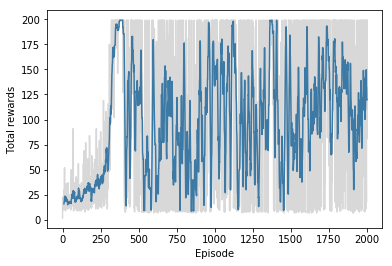

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

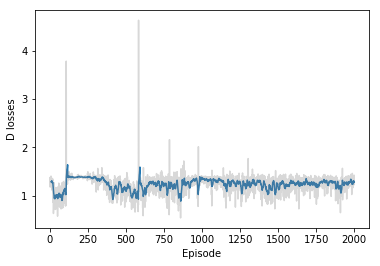

In [20]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

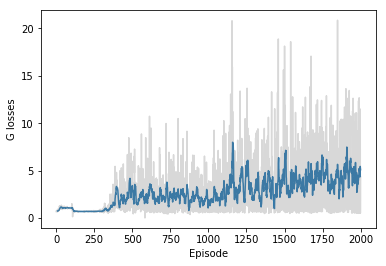

In [21]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

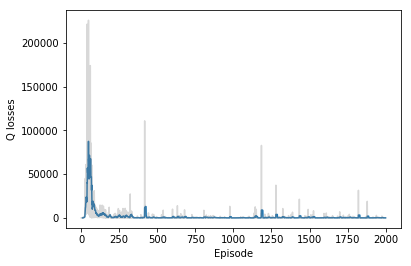

In [22]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [24]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.